# Historic Events

In this notebook we plot historic cold spells in Texas to show their intensity and duration.
We'll use the ERA5 data, for consistency with the "local_return_period" analysis.

In [1]:
import cartopy.crs as ccrs
from cartopy.feature import STATES, COASTLINE
from datetime import datetime
import matplotlib.pyplot as plt
import regionmask
import numpy as np
import xarray as xr

from codebase.fig import figname

We start by loading the data. We'll slice off the most Southern tip of Texas, which doesn't get as cold, and the Western sliver (much love to my friends in El Paso, but you're not in ERCOT)

In [2]:
hdd = (
    xr.open_mfdataset("../data/processed/era5/hdd_*.nc").
    sel(latitude=slice(37, 27), longitude=slice(-106, -92)).
    compute()
)

In [3]:
DURATIONS = [1, 3, 5]

In [4]:
hdd_roll = xr.concat(
    [
        hdd["HDD"].rolling(time=dur).mean().assign_coords({"lag": dur}) for dur in DURATIONS
    ],
    dim="lag",
).rename({"longitude": "lon", "latitude": "lat"}) # rename to work w/ regionmask

Based on **subjective** exploratory analysis, reading newspapers and blogs, and looking at this data, we choose 4 events to plot

In [5]:
EVENTS = [
    ["1951-02-01", "1951-02-01", "1951-02-02"], # 1 day, 3 day, 5 day
    ["1983-12-25", "1983-12-25", "1983-12-26"],
    ["1989-12-23", "1989-12-24", "1989-12-24"],
    ["2011-02-02", "2011-02-04", "2011-02-05"],
    ["2021-02-15", "2021-02-16", "2021-02-16"],
]

**NOTE**: not all data for 2021 is available yet!

We'll plot heating demand days centered on Texas, but we'll include nearby regions

In [6]:
data_proj = ccrs.PlateCarree()
map_proj = ccrs.LambertConformal()
plot_kw = {"levels": np.linspace(33, 68, 15), "cmap": "plasma", "add_colorbar": False, "transform": data_proj}

We apply a filter to show only data over land

In [7]:
countries = regionmask.defined_regions.natural_earth.countries_110
mask = countries.mask(hdd_roll)
usa_idx = countries.map_keys("United States of America")
mexico_idx = countries.map_keys("Mexico")
hdd_land = hdd_roll.where(np.logical_or(mask == usa_idx, mask == mexico_idx))

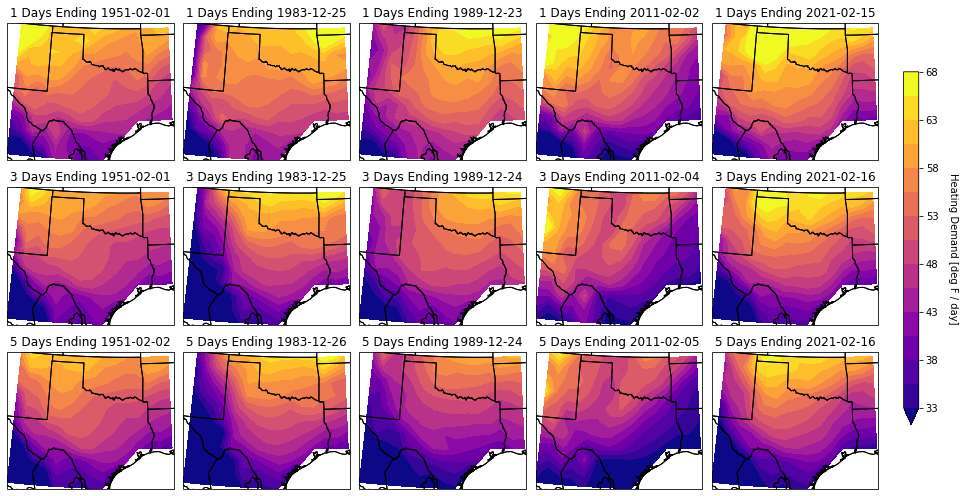

In [8]:
fig, axes = plt.subplots(nrows=len(DURATIONS), ncols=len(EVENTS), figsize=(14, 7), subplot_kw=dict(projection=map_proj), sharex=True, sharey=True)

for col, event in enumerate(EVENTS):
    for row, dur in enumerate(DURATIONS):
        ax = axes[row, col]
        date = event[row]
        C0 = hdd_land.sel(time=date, lag=dur).plot.contourf(ax=ax, **plot_kw)
        ax.set_title(f"{dur} Days Ending {date}")
        ax.add_feature(STATES)
        ax.add_feature(COASTLINE)

# Add  color bars
fig.canvas.draw()
fig.tight_layout()
fig.subplots_adjust(right=0.875)
cax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(C0, cax = cax)
cbar.set_label("Heating Demand [deg F / day]", rotation=270)
cbar.ax.get_yaxis().labelpad = 20

plt.savefig(figname("historic_events_era5.pdf"))
plt.show()

One cool insight is that the 2011 storm was much less severe (over most of Texas) than some others we have witnessed in the historical record.
The 2021 storm strongly affected Oklahoma and North Texas.